In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq 'Cat_Dog_data.zip'

--2019-12-26 16:29:31--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.200.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.200.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip.3’

Cat_Dog_data.zip.3  100%[===================>] 553.60M  45.3MB/s    in 13s     

2019-12-26 16:29:44 (44.1 MB/s) - ‘Cat_Dog_data.zip.3’ saved [580495262/580495262]

replace Cat_Dog_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

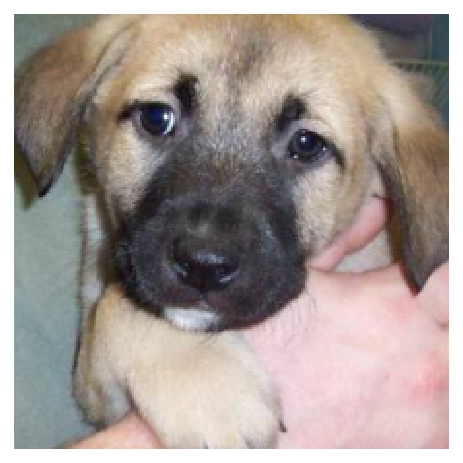

In [4]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt 
import torch 
from torchvision import datasets, transforms 

transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

ROOT = '/content/Cat_Dog_data/train'

data = datasets.ImageFolder(ROOT, transform = transform)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

In [0]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt 
import torch 
from torchvision import datasets, transforms 

train_transform = transforms.Compose([transforms.RandomRotation(180),
                                 transforms.RandomResizedCrop(28),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.RandomResizedCrop(28),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ROOT = '/content/Cat_Dog_data/'

train_data = datasets.ImageFolder(ROOT + 'train', transform = train_transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

test_data = datasets.ImageFolder(ROOT + 'test', transform = test_transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 28, 28])


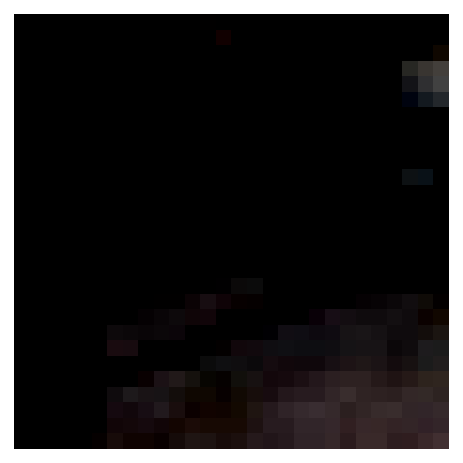

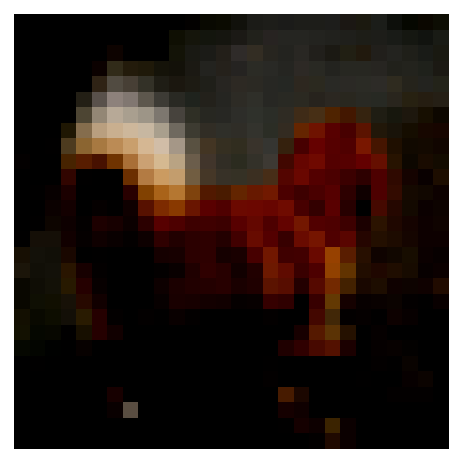

In [6]:
images, labels = next(iter(trainloader))
imshow(images[0], normalize=False)
print(images.shape)
images, labels = next(iter(testloader))
imshow(images[0], normalize=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


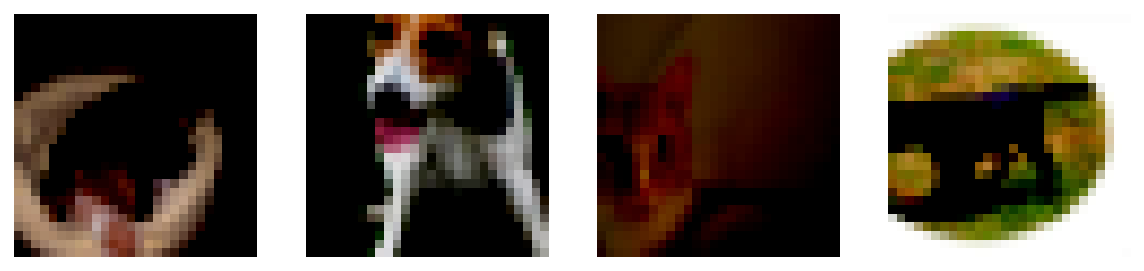

In [7]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

In [8]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784*3, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 2)

    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):

    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

if torch.cuda.is_available():
  device = torch.device("cuda:0")
model = Net().to(device)
model


Net(
  (fc1): Linear(in_features=2352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [9]:
import torch.optim as optim 
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.NLLLoss()
EPOCHS = 3

for epoch in range(EPOCHS):

  acc = 0
  running_loss = 0
  testing_loss = 0

  for images, labels in trainloader:

    optimizer.zero_grad()

    images = images.view(-1, 784*3)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images).to(device)
    
    loss = criterion(outputs, labels)
    loss.backward()
    running_loss += loss.item()

    optimizer.step()

  else:
    with torch.no_grad():
      for images, labels in testloader:
        images = images.view(-1, 3*784)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).to(device)

        loss = criterion(outputs, labels)
        testing_loss += loss.item()

        top_k, top_label = outputs.topk(1, dim=1)
        equal = top_label == labels.view(*top_label.shape)
        acc += torch.mean(equal.type(torch.float))

    print(f"Epoch {epoch+1}/{EPOCHS}..")
    print(f"Training loss : {running_loss/len(trainloader)}")
    print(f"Testing loss : {testing_loss/len(testloader)}")
    print(f"Accuracy : {100*acc/len(testloader)} %%")

Epoch 1/3..
Training loss : 0.6964508079161699
Testing loss : 0.6947002539151832
Accuracy : 49.76266098022461 %%
Epoch 2/3..
Training loss : 0.6952443767169659
Testing loss : 0.695185388945326
Accuracy : 50.07911682128906 %%
Epoch 3/3..
Training loss : 0.6935072335499254
Testing loss : 0.6930567546735836
Accuracy : 49.802215576171875 %%
